In [219]:
#to see the output please go the last cell

#Import the necessary libraries
import cv2                         #for image processing
import numpy as np                 #to handle array and array related operation
import os                          #to interact with storage
from PIL import Image              #to show the image
from itertools import combinations #to apply combination
import math                        #to use the sqrt funtion while caculating distance

In [220]:
#path for label file, config file and weights
label_path = "coco.names"
config_path = "yolov3.cfg"
weight_path = "yolov3.weights"

In [221]:
#to extract labels from the file
labels = open(label_path).read().strip().split("\n")
#common image dimension for image processing
yolo_shape= (416,416)

#to use darknet and include yolo
network = cv2.dnn.readNetFromDarknet(config_path, weight_path)

#to get the layers
ln = network.getUnconnectedOutLayersNames()

In [222]:
#importing the image and preprocessing
#img = cv2.imread('image1.jpg')
#img2 = cv2.imread('image1.jpg')
img = cv2.imread('Screenshot_2020-06-13_at_7.41.41_AM.png')
img2 = cv2.imread('Screenshot_2020-06-13_at_7.41.41_AM.png')
H, W = img.shape[:2]

#preprocessing
Pre_image = cv2.dnn.blobFromImage(img, 1/255.0, yolo_shape, swapRB = True)

In [223]:
#giving the Pre_image as input to the network
network.setInput(Pre_image)

#forwarding it for detection and getting outputs
LayerOuts = network.forward(ln)

#to save the coordinates of all the persons detected
coordinates = {}
Id = 0

#to save all the persons which are to be red boxed
red_box = []

In [224]:
#function to detect the persons in the image
def Person_detection(Id,coordinates):
    print("Detection has started")
    
    #to iterate through all the outputs obtained after feeding the image to the network
    for output in LayerOuts:
        #to iterate throught the output in output
        for detection in output:
            #score tells the different classes predicted with how much probability
            score = detection[5:]
            #we select the index of the most highest one
            classId = np.argmax(score)
            #we find the value find the actual score
            confidence = score[classId]
            #if to first eliminate other objects with less scores
            #and than to make a dictionary of only the onces with person label
            if confidence > 0.8:
                Object = labels[classId]
                if Object == "person":
                    #the coordinates of the object
                    #(centerX,centerY,width,height)
                    (x, y , w, h) = (detection[:4] * np.array([W,H,W,H])).astype("int")
                    X, Y = int(x-(w/2)), int(y-(h/2))
                    #inserting the values in the dictionary with unique Id
                    coordinates[Id] = (int(x), int(y), X, Y, X+w, y+h)
                    Id+=1

In [225]:
#function to find the distance between 2 persons
def closeornot(dx,dy):
    return math.sqrt(abs(dx)+abs(dy))

In [226]:
#to generate the image with red boxes for risked people and green for safe people
def social_distance_img_gen():
    print("Here is you output")
    #loop to find the distance using different combinations of items in pairs fromm coordintes
    for (id1, p1),(id2,p2) in combinations(coordinates.items(),2):
        #to find the distance
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        distance = closeornot(dx,dy)
        #if the distance is less we do not include them in the red_box for assurance 
        if (abs(p1[0]-p2[0]) < 10) and (abs(p1[1]-p2[1]) <10):
            continue
        else:
            #if they are close than only the condition is satisfies
            if distance < 12.0:
                #to check not to have repeated ids in red_box
                if id1 not in red_box:
                    red_box.append(id1)
                if id2 not in red_box:
                    red_box.append(id2)
    #loop to draw the rectangle around the persons using red_box list
    for idx, box in coordinates.items():
        if idx in red_box:
            cv2.rectangle(img2, (box[2],box[3]),(box[4],box[5]),(255,0,0),2)
        else:
            cv2.rectangle(img2,(box[2],box[3]),(box[4],box[5]),(0,255,0),2)
    cv2.imwrite("newimg.png",img2)

In [227]:
#to remove extra boxes
def filter_the_output():
    print("We are now filtering the output")
    #loop to delete the object data from coordinates which might be there due to predicting
    #the same object number of times
    for (id1, p1),(id2,p2) in combinations(coordinates.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        if (abs(dx)<10) and (abs(dy)<10):
            del coordinates[id1]

In [228]:
def main_function():
    Person_detection(Id,coordinates)
    social_distance_img_gen()

Detection has started
Here is you output


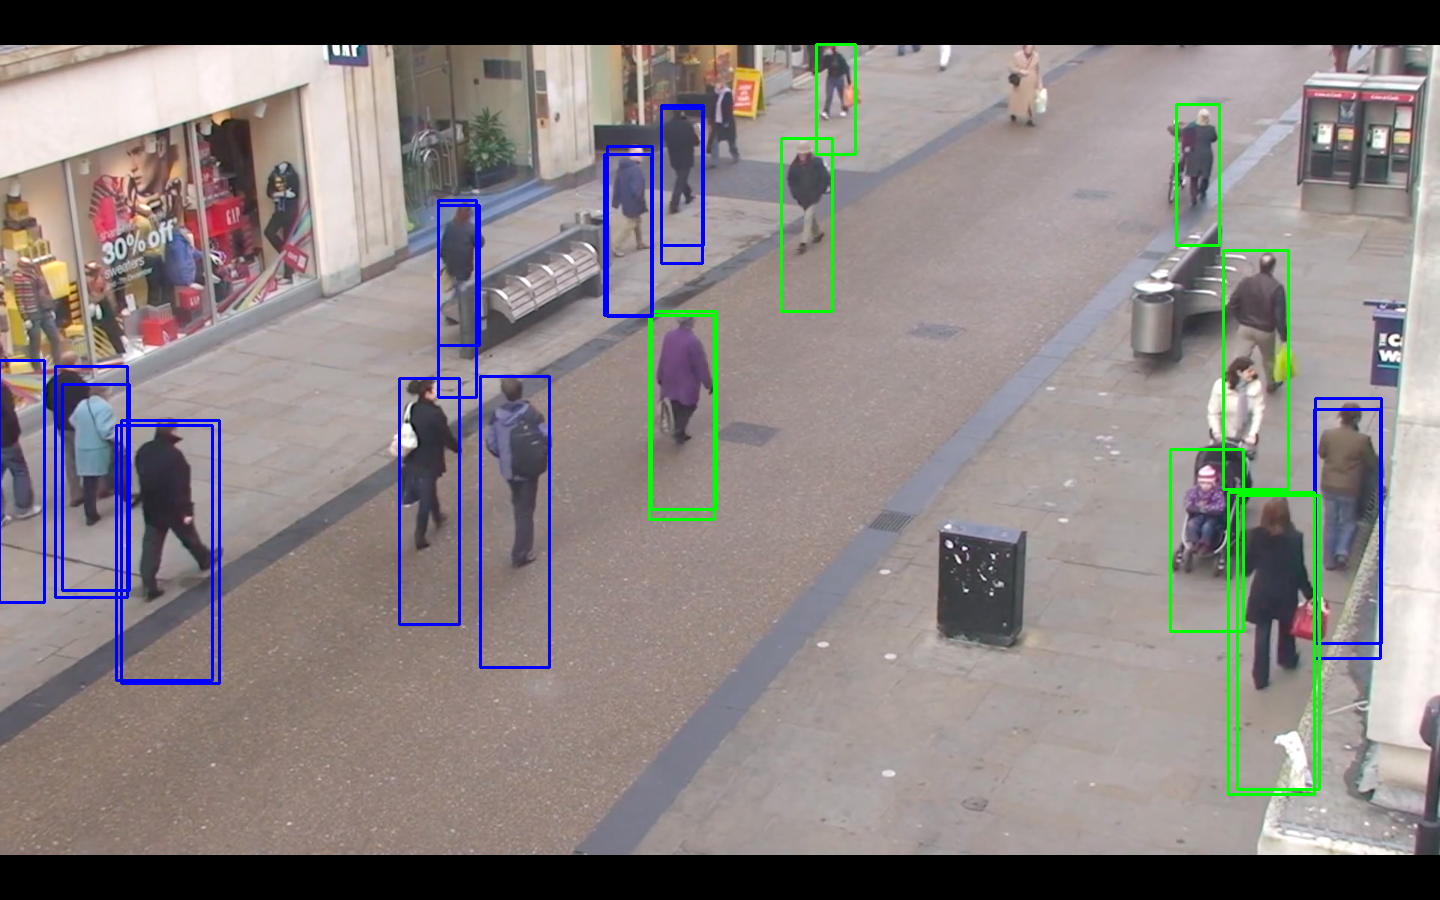

In [229]:
main_function()
Image.open("newimg.png")